In [10]:
# Import Libraries
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pyplot as plt
import os
import zipfile
import csv
from tensorflow import keras
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import pandas as pd

In [11]:
# Extract the dataset
with zipfile.ZipFile('/content/fruits.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/')

In [12]:
# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)
data_root = ('/content/data/fruits')
tf.config.optimizer.set_jit(True)
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)

In [13]:
# Intialise Validation Set
datagen_kwargs = dict(rescale=1./255, validation_split=0.10)
valid_datagen = keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR,
    subset="validation",
    shuffle=True,
    target_size=IMAGE_SHAPE
)

Found 463 images belonging to 5 classes.


In [14]:
# Initialise Training Set
train_datagen = keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR,
    subset="training",
    shuffle=True,
    target_size=IMAGE_SHAPE)

Found 4190 images belonging to 5 classes.


In [15]:
# Intialise labels
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'apple': 0, 'banana': 1, 'mango': 2, 'peach': 3, 'pear': 4}


In [16]:
# Build the model
IMAGE_SIZE = 224

model = keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
                 output_shape=[1280],
                 trainable=False,
                 ),
  #keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])

model.build([None,224,224,3])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [17]:
# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=3e-4) #1e-3, 3e-4

model.compile(
  optimizer=optimizer,
  loss= 'categorical_crossentropy',
  metrics=['accuracy']
  )

In [18]:
# Fit the model
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=40,
                    validation_data=valid_generator,
                    validation_steps= val_steps_per_epoch,
                    verbose=1
                    )

Epoch 1/40
131/131 [==============================] - 25s 142ms/step - loss: 1.3396 - accuracy: 0.4575 - val_loss: 0.9837 - val_accuracy: 0.6609
Epoch 2/40
131/131 [==============================] - 25s 187ms/step - loss: 0.8841 - accuracy: 0.7002 - val_loss: 0.7526 - val_accuracy: 0.7473
Epoch 3/40
131/131 [==============================] - 14s 110ms/step - loss: 0.6955 - accuracy: 0.7709 - val_loss: 0.6407 - val_accuracy: 0.7689
Epoch 4/40
131/131 [==============================] - 14s 110ms/step - loss: 0.5918 - accuracy: 0.8088 - val_loss: 0.5663 - val_accuracy: 0.7927
Epoch 5/40
131/131 [==============================] - 14s 109ms/step - loss: 0.5260 - accuracy: 0.8274 - val_loss: 0.5173 - val_accuracy: 0.8164
Epoch 6/40
131/131 [==============================] - 14s 109ms/step - loss: 0.4797 - accuracy: 0.8418 - val_loss: 0.4855 - val_accuracy: 0.8207
Epoch 7/40
131/131 [==============================] - 14s 110ms/step - loss: 0.4446 - accuracy: 0.8535 - val_loss: 0.4562 - val_ac

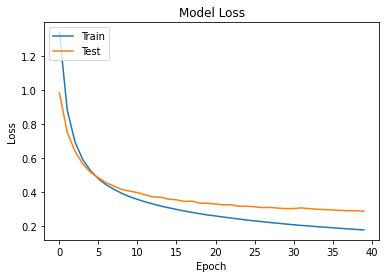

In [19]:
# Plot loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('/content/loss.png')
plt.show()

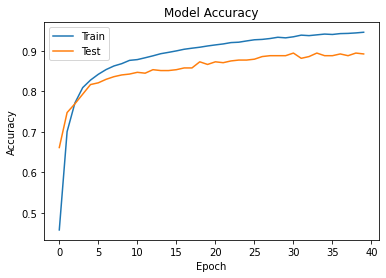

In [20]:
# Plot Accuracy Graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('/content/accuracy.png')
plt.show()

In [22]:
# Convert to Tflite model for classification on mobile
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()
open("/content/fruits.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp4bnjdepm/assets


INFO:tensorflow:Assets written to: /tmp/tmp4bnjdepm/assets


8915716